In [2]:
import pandas as pd
import ast  # 문자열로 된 데이터를 진짜 파이썬 데이터(딕셔너리)로 바꿔주는 도구
import re   # 단어를 찾을 때 쓰는 '정규표현식' 도구

# 파일 경로 설정
input_file = '/Users/jun/Desktop/DBpia_trend/DBpia 논문 메타데이터/SSU_Datathon2025_공학분야_62199.json'
output_file = 'dbpia_papers.csv'

In [3]:
import re
# 영문 약어 (독립 단어로 검색: \b 사용)
# 'air', 'railway', 'daily', 'main' 등에 포함된 'ai'를 걸러내기
english_keywords = ['AI', 'ML', 'DL', 'LLM', 'GPT', 'SOTA', 'CNN', 'RNN', 'VLM']
en_pattern = '|'.join([rf'\b{re.escape(k)}\b' for k in english_keywords])

# 긴 영문 구문 및 국문 키워드
# 이 단어들은 길어서 'air' 같은 단어에 낚일 염려가 없으므로 일반 검색을 수행
long_keywords = [
    'Machine Learning', 'Deep Learning', 'Neural Network', 'Computer Vision',
    'Natural Language Processing', 'Generative AI', 'Vision-Language Model',
    '인공지능', '인공 지능', '머신러닝', '기계학습', '딥러닝', '신경망',
    '지능형', '강화학습', '거대언어모델', '생성형 AI', '컴퓨터 비전', '자연어 처리'
]
long_pattern = '|'.join([re.escape(k) for k in long_keywords])

# 최종 검색 패턴 (영어 약어 패턴 또는 긴 구문 패턴)
# re.IGNORECASE를 사용할 것이므로 소문자 ai도 자동 검색
final_pattern = f"({en_pattern})|({long_pattern})"

print(f"패턴 생성 완료: {len(english_keywords) + len(long_keywords)}개의 키워드가 적용되었습니다.")

패턴 생성 완료: 28개의 키워드가 적용되었습니다.


In [4]:
import ast

ai_papers_list = []
skipped_count = 0

with open(input_file, 'r', encoding='utf-8') as f:
    f.readline()

    for line in f:
        line = line.strip()
        if not line: continue

        try:
            if line.startswith('"') and line.endswith('"'):
                line = line[1:-1]
            item = ast.literal_eval(line)

            content_to_check = f"""
                {item.get('NODE_TTLE', '')}
                {item.get('NODE_TTLE_EN', '')}
                {item.get('KYWD', '')}
                {item.get('KR_ABST', '')}
                {item.get('EN_ABST', '')}
            """

            if re.search(final_pattern, content_to_check, flags=re.IGNORECASE):
                ai_papers_list.append(item)

        except Exception:
            skipped_count += 1
            continue

print(f"--- 필터링 결과 ---")
print(f"최종 추출된 AI 논문: {len(ai_papers_list)}개")
print(f"에러로 건너뛴 데이터: {skipped_count}개")

--- 필터링 결과 ---
최종 추출된 AI 논문: 7302개
에러로 건너뛴 데이터: 1867개


In [5]:
# 결과 저장
if ai_papers_list:
    # 바구니에 담긴 데이터를 표 형태로 변환
    df_final = pd.DataFrame(ai_papers_list)

    # CSV 파일로 저장
    df_final.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"{output_file} 파일 생성완료")
else:
    print("error")

dbpia_papers.csv 파일 생성완료


In [9]:
import pandas as pd

# 논문 데이터 불러오기
df = pd.read_csv('/Users/jun/Desktop/DBpia_trend/dbpia_papers.csv')

# 연도(year) 컬럼 만들기 (PBSH의 앞 4자리)
df['year'] = df['PBSH'].astype(str).str[:4]

# 통합 파일 저장
df.to_csv('/Users/jun/Desktop/DBpia_trend/dbpia_papers.csv', index=False, encoding='utf-8-sig')

In [22]:
# 영문 초록(EN_ABST)이 비어있는(NaN) 논문 개수 확인
missing_en = df['ABST_EN'].isna().sum()
total = len(df)
print(f"영문 초록이 없는 논문: {missing_en}개 (전체의 {missing_en/total:.1%})")

# 영문 초록이 없는 데이터 제거
df_en = df.dropna(subset=['ABST_EN']).copy()

영문 초록이 없는 논문: 871개 (전체의 11.9%)


### 중간 점검
메타데이터 내의 키워드 기반으로 인공지능 관련 논문들을 모아 dbpia_papers.csv 파일을 만들었다. 영문 초록이 없는 논문은 전체의 11.9퍼센트로, 분석의 편의를 위해 제거했다.

In [23]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# 분석을 위한 텍스트 합치기 (영문 제목 + 영문 초록)
docs = (df_en['NODE_TTLE_EN'].fillna('') + " " + df_en['ABST_EN']).tolist()

# c-TF-IDF
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# 불용어 및 빈도수 필터링
vectorizer_model = CountVectorizer(stop_words="english", min_df=10)

# BERTopic 학습
print("BERTopic 학습 시작 (약 2~3분 소요)...")
topic_model = BERTopic(
    ctfidf_model=ctfidf_model,
    vectorizer_model=vectorizer_model,
    embedding_model="all-MiniLM-L6-v2",
    nr_topics="auto",
    verbose=True
)

topics, probs = topic_model.fit_transform(docs)

# 노이즈(-1)를 가장 가까운 토픽으로 강제 배정 (에러 방지용 strategy="embeddings")
embeddings = topic_model._extract_embeddings(docs, method="document")
new_topics = topic_model.reduce_outliers(docs, topics, strategy="embeddings", embeddings=embeddings)
topic_model.update_topics(docs, topics=new_topics)

# 결과
print(topic_model.get_topic_info().head(11))

2026-01-28 16:14:34,486 - BERTopic - Embedding - Transforming documents to embeddings.


BERTopic 학습 시작 (약 2~3분 소요)...


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1011.47it/s, Materializing param=pooler.dense.weight]                            
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 201/201 [00:40<00:00,  5.01it/s]
2026-01-28 16:15:18,643 - BERTopic - Embedding - Completed ✓
2026-01-28 16:15:18,644 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-28 16:15:20,337 - BERTopic - Dimensionality - Completed ✓
2026-01-28 16:15:20,338 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-28 16:15:20,447 - BERTopic - Cluster - Completed ✓
2026-01-28 16:15:20,447 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2026

노이즈 제거 중...


2026-01-28 16:16:00,477 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


--- 정제 완료된 상위 10개 토픽 리스트 ---
    Topic  Count                                   Name  \
0       0   1435                        0_the_of_and_in   
1       1    321               1_language_korean_the_of   
2       2    239         2_ai_generative_design_content   
3       3    271      3_energy_power_battery_prediction   
4       4    318                       4_the_deep_of_in   
5       5    168     5_price_stock_prediction_financial   
6       6    138    6_education_ai_students_educational   
7       7    148               7_ai_ethical_defense_and   
8       8    162   8_adversarial_recognition_image_text   
9       9    176  9_reinforcement_learning_agent_reward   
10     10    110  10_recommendation_reviews_review_user   

                                       Representation  \
0   [the, of, and, in, to, detection, for, model, ...   
1   [language, korean, the, of, and, to, in, model...   
2   [ai, generative, design, content, and, product...   
3   [energy, power, battery, predi

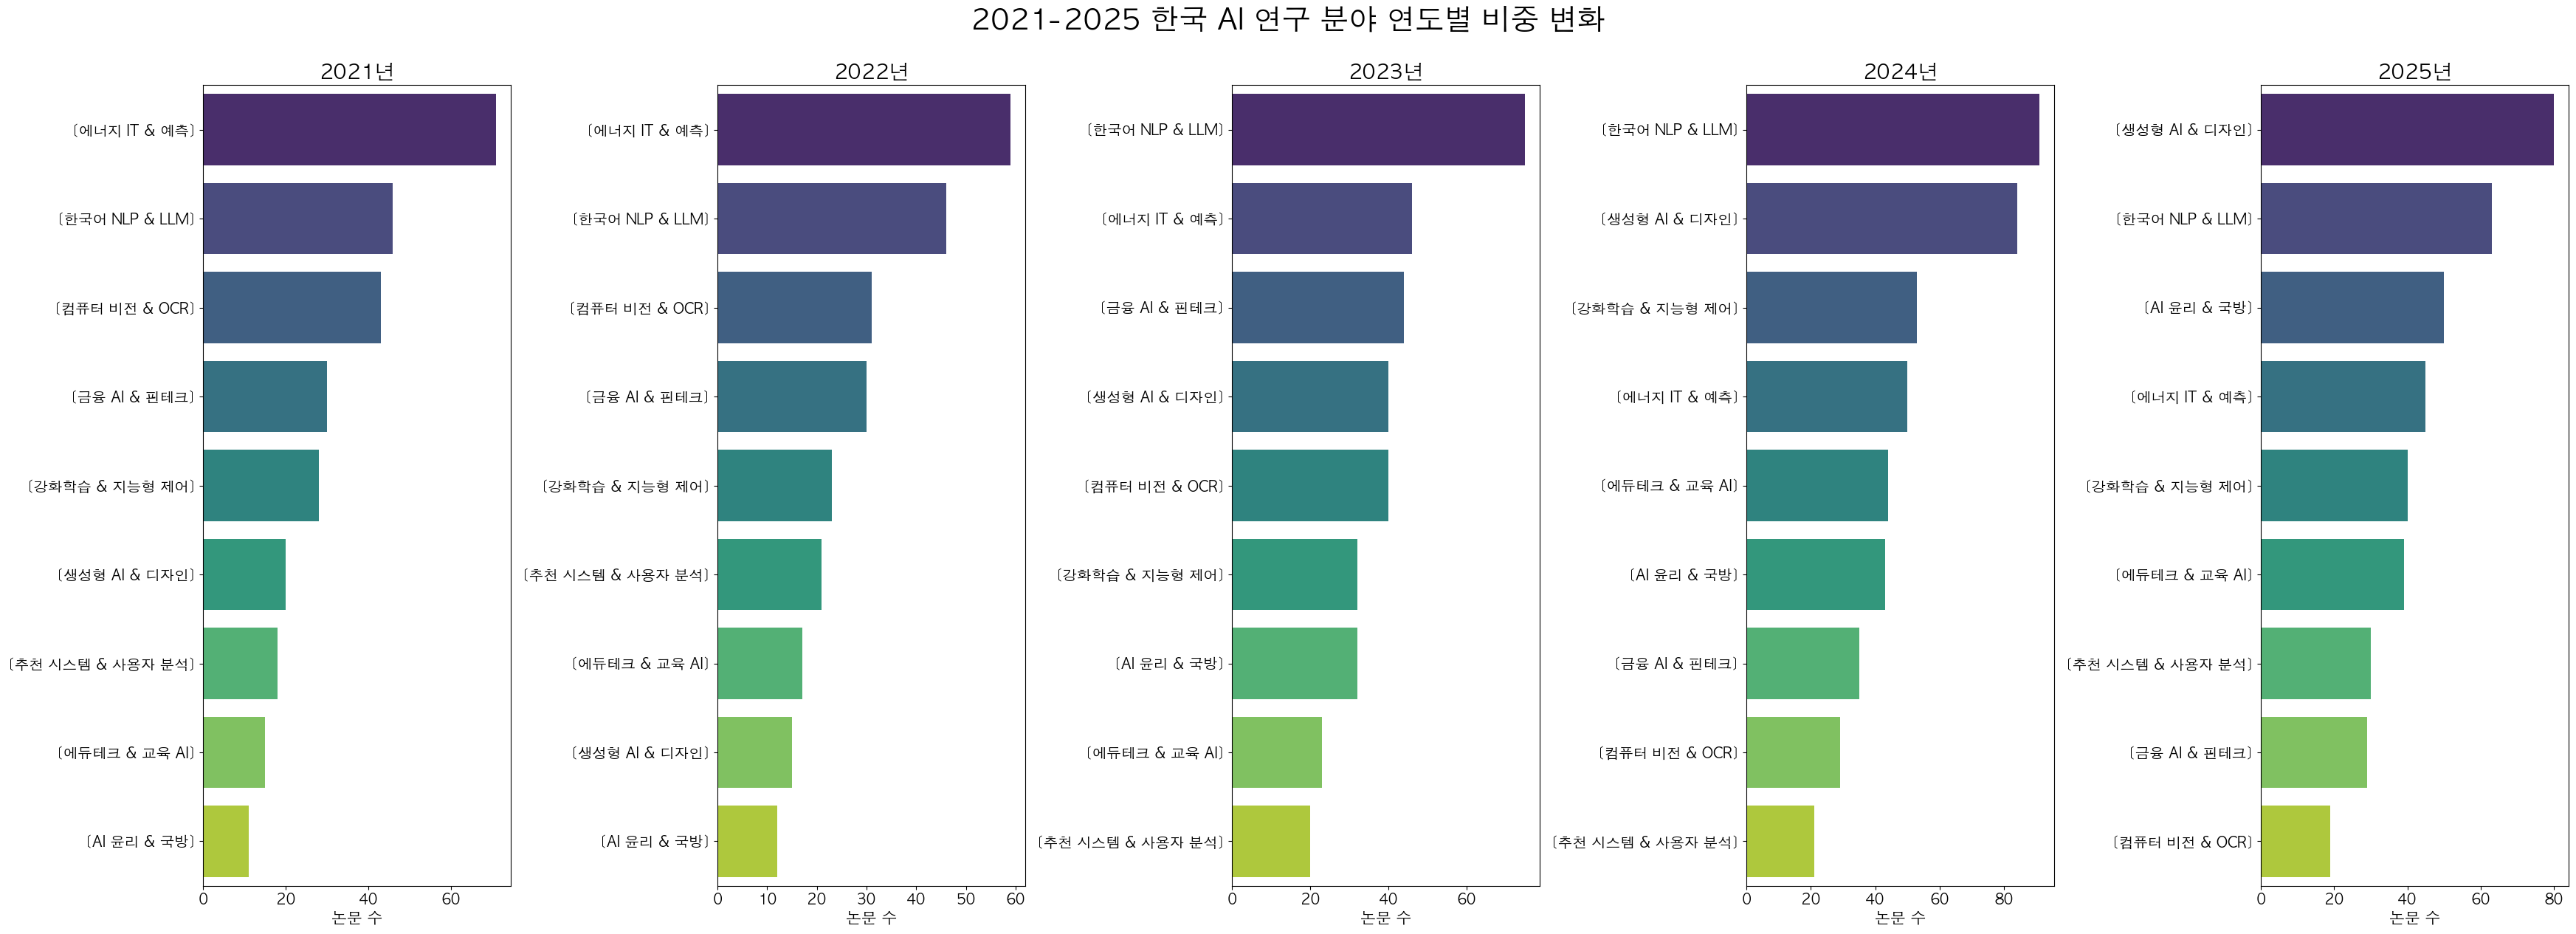

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import platform

# 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경일 때
    plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# 데이터프레임에 토픽 정보가 없는 경우를 대비해 다시 할당
df_en['topic'] = new_topics

# 0, 4번 토픽을 제외
target_topics = [1, 2, 3, 5, 6, 7, 8, 9, 10]
df_relevant = df_en[df_en['topic'].isin(target_topics)].copy()

# 그래프 설정
years = sorted(df_relevant['year'].unique())
fig, axes = plt.subplots(1, 5, figsize=(35, 12), sharey=False)

for i, year in enumerate(years):
    year_data = df_relevant[df_relevant['year'] == year]

    # 해당 연도 토픽 빈도 계산
    top_topics = year_data['topic'].value_counts().reset_index()
    top_topics.columns = ['topic', 'count']

    # 한국어 라벨로 변경
    top_topics['topic_name'] = top_topics['topic'].map(topic_labels)

    # 시각화
    sns.barplot(x='count', y='topic_name', data=top_topics, ax=axes[i], palette='viridis')

    # 그래프 상세 설정
    axes[i].set_title(f"{year}년", fontsize=20, fontweight='bold')
    axes[i].set_xlabel("논문 수", fontsize=15)
    axes[i].set_ylabel("")
    axes[i].tick_params(axis='both', which='major', labelsize=14)

# 전체 제목 설정
plt.tight_layout()
plt.suptitle('2021-2025 한국 AI 연구 분야 연도별 비중 변화', fontsize=28, y=1.05, fontweight='bold')
plt.show()

In [25]:
import pandas as pd

# 시각화 대상 토픽 및 한국어 라벨 정의 (0, 4번은 제외)
topic_labels = {
    1: "[한국어 NLP & LLM]",
    2: "[생성형 AI & 디자인]",
    3: "[에너지 IT & 예측]",
    5: "[금융 AI & 핀테크]",
    6: "[에듀테크 & 교육 AI]",
    7: "[AI 윤리 & 국방]",
    8: "[컴퓨터 비전 & OCR]",
    9: "[강화학습 & 지능형 제어]",
    10: "[추천 시스템 & 사용자 분석]"
}

# 모델에 커스텀 라벨 적용
topic_model.set_topic_labels(topic_labels)

# 시간에 따른 토픽 변화 계산
timestamps = pd.to_datetime(df_en['year'].astype(str), format='%Y').tolist()
topics_over_time = topic_model.topics_over_time(docs, timestamps)

# 시각화 실행
fig = topic_model.visualize_topics_over_time(
    topics_over_time,
    topics=list(topic_labels.keys()),
    custom_labels=True,
    title='<b>2021-2025 국내 AI 연구 트렌드 분석</b>'
)

# 그래프 출력
fig.show()

# 연도별 수치 요약 확인
filtered_tot = topics_over_time[topics_over_time['Topic'].isin(topic_labels.keys())]
trend_pivot = filtered_tot.pivot(index='Timestamp', columns='Topic', values='Frequency').fillna(0)

trend_pivot.columns = [topic_labels[t] for t in trend_pivot.columns]

print("--- 연도별 주요 토픽 발생 빈도(건수) 상세 수치 ---")
print(trend_pivot)

5it [00:01,  3.74it/s]


--- 연도별 주요 토픽 발생 빈도(건수) 상세 수치 ---
            [한국어 NLP & LLM]  [생성형 AI & 디자인]  [에너지 IT & 예측]  [금융 AI & 핀테크]  \
Timestamp                                                                   
2021-01-01               46              20             71             30   
2022-01-01               46              15             59             30   
2023-01-01               75              40             46             44   
2024-01-01               91              84             50             35   
2025-01-01               63              80             45             29   

            [에듀테크 & 교육 AI]  [AI 윤리 & 국방]  [컴퓨터 비전 & OCR]  [강화학습 & 지능형 제어]  \
Timestamp                                                                   
2021-01-01              15            11              43               28   
2022-01-01              17            12              31               23   
2023-01-01              23            32              40               32   
2024-01-01              44            43 

### 한국의 인공지능 연구를 관통하는 가장 큰 특징: 도메인 융합
단순히 AI 알고리즘 자체를 연구하는 것보다, 에너지/금융/교육/디자인 등 한국의 실제 산업계가 당면한 과제들을 AI로 해결하려는 실용주의적 트렌드가 매우 강하게 드러난다. 국내 연구가 이토록 실용적 도메인 융합에 집중하고 있다면, 그 원천이 되는 글로벌 기술 동향은?